In [1]:
from __future__ import division, print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Introduction to packaged samplers

In this notebook, we introduce two package samplers that you might consider using. The advantage of using a packaged sampler is they are usually well tested, well documented, and come with lots of bells and whistles.

We will discuss just two examples and there are many more on the market

* For a great overview at a code level see [Matt Pitkin's comparison](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/).

* You can also find a good review article on the topic by [Allison & Dunkley](https://academic.oup.com/mnras/article/437/4/3918/1011939).

## emcee: the MCMC hammer

Dan Foreman-Mackay and others wrote [`emcee`](http://emcee.readthedocs.io/en/stable/) which is highy popular. I think a good part of this is because it is well written. The second part is that it implents the [Goodman & Weare 
"Ensemble samplers with affine invariance"](https://msp.org/camcos/2010/5-1/p04.xhtml). We'll get onto the meaning of that in a moment. First up a practical example: 

### The problem

Let's say we have some data $x_i, y_i$ where $i \in [1, N]$ which we believe was generated as follows:

First there is a 'signal'

$$ y(x) = A \mathrm{sin}\left(2\pi f x + \phi\right) $$

But the data is observed subject to additive white Gaussian noise, i.e.

$$ y_i = y(x_i) + n_i $$

where

$$ n_i \sim \mathrm{Normal}(0, \sigma) $$

and $\sigma$ is the unknown standard deviation of the noise.

Let's generate soem fake data with some 'injection' values.

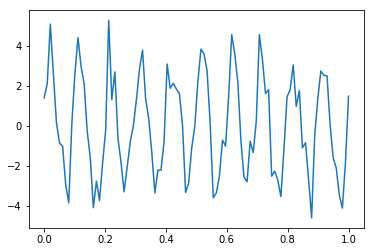

In [2]:
A = 3
f = 10
phi = 0.4
sigma = 1
N = 100
x = np.linspace(0, 1, N)
y = A * np.sin(2*np.pi*f*x + phi) + np.random.normal(0, sigma, N)
plt.plot(x, y)
plt.show()

### The probablistic model

Okay, so how can we go about inferring what $A, f, \phi$ and $\sigma$ are given just the data and the mode?

The first thing we notice is
$$ y_i - y(x_i) = n_i \sim \mathrm{Normal}(0, \sigma) $$
From which we can write down a likelihood of the data
$$ \Rightarrow P(y_i, x_i | A, f, \phi, \sigma) = 
\frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}
\left(\frac{-\left(y_i - y(x_i; A, f, \phi, \sigma)\right)^2}{2\sigma^2}\right)$$

Okay, let's show how to implement this in `emcee`. The `emcee` packages requires the log of the liklihood and prior for numerical stability. We'll also implement uniform priors for simplicity. 

In [3]:
def log_likelihood(theta, x, y):
    A, f, phi, sigma = theta
    model = A * np.sin(2*np.pi*f*x + phi)
    res = y - model
    return -0.5 * np.sum(res**2 / (2*sigma**2)
                         + np.log(np.sqrt(2*np.pi*sigma**2)))

def log_prior(theta):
    A, f, phi, sigma = theta
    logp = 0
    if 0 < A and A < 5:
        logp += np.log(1/10)
    else:
        return -np.inf
    if 0 < f and f < 20:
        logp += np.log(1/20)
    else:
        return -np.inf
    if 0 < phi and phi < 2*np.pi:
        logp += np.log(1/(2*np.pi))
    else:
        return -np.inf
    if 0 < sigma and sigma < 2:
        logp += np.log(1/2)
    else:
        return -np.inf
    return logp
    

The `emcee` package provides something called the `EnsembleSampler`, let's take a look at its documentations:

In [4]:
import emcee
emcee.EnsembleSampler?

```python
Init signature: emcee.EnsembleSampler(self, nwalkers, dim, lnpostfn, a=2.0,
                                      args=[], kwargs={}, postargs=None, threads=1,
                                      pool=None, live_dangerously=False,
                                      runtime_sortingfn=None)

...

:param nwalkers:
    The number of Goodman & Weare "walkers".

:param dim:
    Number of dimensions in the parameter space.

:param lnpostfn:
    A function that takes a vector in the parameter space as input and
    returns the natural logarithm of the posterior probability for that
    position.

:param args: (optional)
    A list of extra positional arguments for ``lnpostfn``. ``lnpostfn``
    will be called with the sequence ``lnpostfn(p, *args, **kwargs)``
... 
```

In [5]:
def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)
    
# Run it for a few hundred steps
nwalkers= 100
ndim = 4
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
pos = [1e-4*np.random.randn(ndim) for i in range(nwalkers)]
out = sampler.run_mcmc(pos, 300)

/home/user1/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/user1/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


That will take a few seconds to complete. What have we made? Well, you'll see we can access something called the `chains` from the sampler object.

In [6]:
sampler.chain.shape

(100, 300, 4)

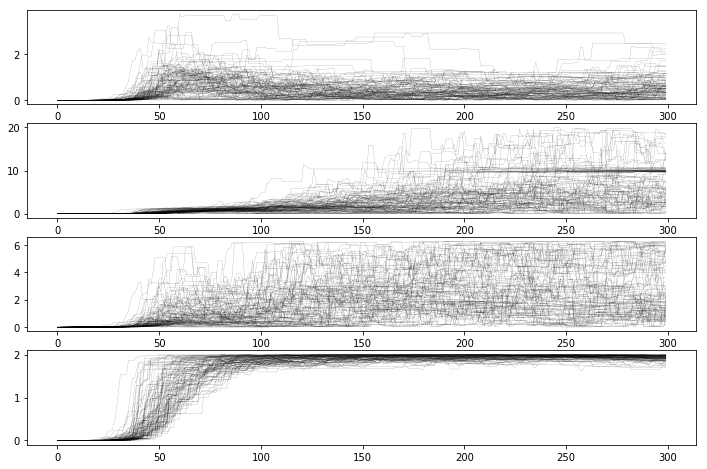

In [7]:
fig, axes = plt.subplots(nrows=ndim, figsize=(12, 8))
for i, ax in enumerate(axes):
    ax.plot(sampler.chain[:, :, i].T, color='k', lw=0.1)

## Key points about emcee

* It's an ensemble sampler - this means it runs `nwalkers` MCMC-chains in parallel. Each talks to all other chains.
* There is a tuning parameter `a`, but in general you do not need to use it.
* It is affine invariant - so it will sample highly anisotropic distributions efficiently.
* It needs an initial position for the samplers - choosing 0, 0, 0, 0 is not a good idea!

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
# Initialise the walkers from around the posterior
pos = [np.array([A, f, phi, sigma]) + np.random.uniform(0, 0.1, ndim)
       for i in range(nwalkers)]
out = sampler.run_mcmc(pos, 1000)

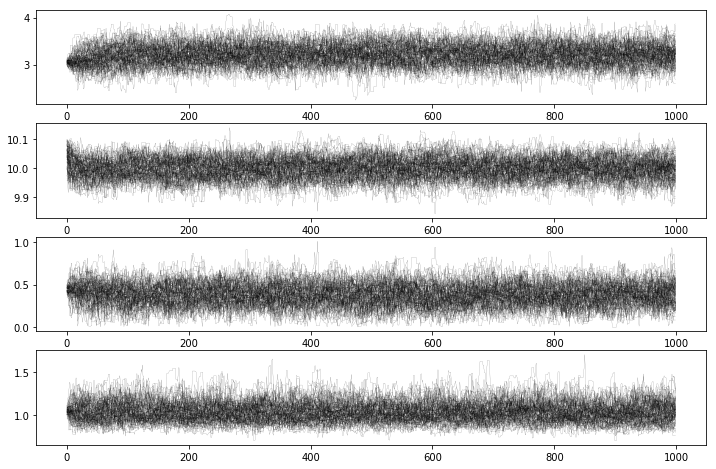

In [9]:
fig, axes = plt.subplots(nrows=ndim, figsize=(12, 8))
for i, ax in enumerate(axes):
    ax.plot(sampler.chain[:, :, i].T, color='k', lw=0.1)

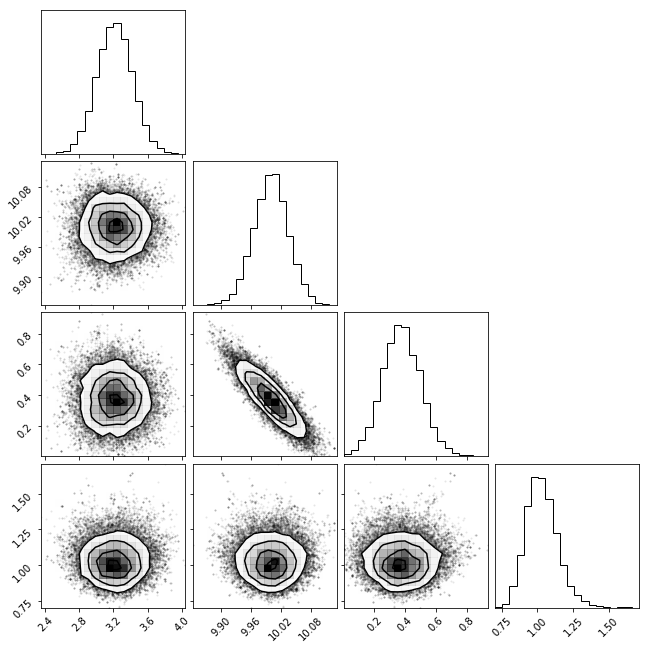

In [10]:
import corner

samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
corner.corner(samples)
plt.show()

## Dynesty: Nested sampling

In [11]:
import dynesty
from dynesty import NestedSampler
NestedSampler?

```python
Signature: NestedSampler(loglikelihood, prior_transform, ndim, nlive=250,
                         bound='multi', sample='unif', update_interval=0.6,
                         first_update=None, npdim=None, rstate=None,
                         queue_size=None, pool=None, use_pool=None,
                         live_points=None, logl_args=None, logl_kwargs=None,
                         ptform_args=None, ptform_kwargs=None, enlarge=None,
                         bootstrap=None, vol_dec=0.5, vol_check=2.0, walks=25,
                         facc=0.5, slices=5, **kwargs)
Docstring:
Initializes and returns a sampler object for Static Nested Sampling.

Parameters
----------
loglikelihood : function
    Function returning ln(likelihood) given parameters as a 1-d `~numpy`
    array of length `ndim`.

prior_transform : function
    Function translating a unit cube to the parameter space according to
    the prior. The input is a 1-d `~numpy` array with length `ndim`, where
    each value is in the range [0, 1). The return value should also be a
    1-d `~numpy` array with length `ndim`, where each value is a parameter.
    The return value is passed to the loglikelihood function. For example,
    for a 2 parameter model with flat priors in the range [0, 2), the
    function would be::

        def prior_transform(u):
            return 2.0 * u

ndim : int
    Number of parameters returned by `prior_transform` and accepted by
    `loglikelihood`.

nlive : int, optional
    Number of "live" points. Larger numbers result in a more finely
    sampled posterior (more accurate evidence), but also a larger
    number of iterations required to converge. Default is `250`.
```

In [12]:
# Define our uniform prior via the prior transform.
def prior_transform(theta):
    return np.array([10, 20, 2*np.pi, 2]) * theta

sampler = NestedSampler(log_likelihood, prior_transform, ndim,
                        nlive=1000, sample='rwalk', logl_args=(x, y))

In [13]:
sampler.run_nested()

iter: 11475+1000 | bound: 329 | nc: 1 | ncall: 233131 | eff(%):  5.351 | loglstar:   -inf < -69.787 <    inf | logz: -83.668 +/-  0.205 | dlogz:  0.011 >  5.005            

In [14]:
r = sampler.results
r.summary()

Summary
nlive: 1000
niter: 11475
ncall: 233131
eff(%):  5.351
logz: -83.668 +/-  0.205


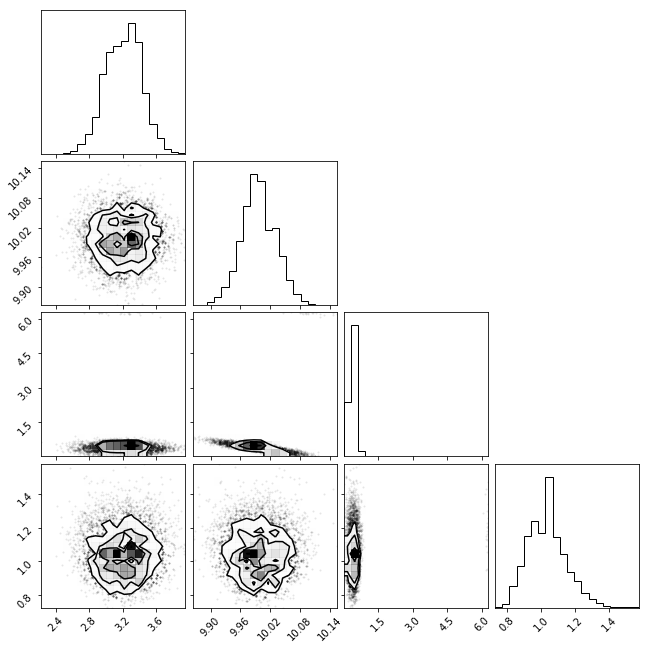

In [15]:
weights = np.exp(r.logwt - r.logz[-1])
samples = dynesty.utils.resample_equal(r.samples, weights)

corner.corner(samples)
plt.show()

## Extension ideas/challenges

* Compare the samples produced by emcee and dynesty - which is faster / better?
* Try to use the `PTSampler` of `emcee` to calculate the evidence (hint - take a look at [this API]( http://dfm.io/emcee/current/api/?highlight=evidence#emcee.PTSampler.thermodynamic_integration_log_evidence))
* Check out [this post](http://kylebarbary.com/nestle/prior.html) on the prior transform and how to write non-uniform priors for nested samplers.